<a href="https://colab.research.google.com/github/prubnur/drowsiness-detection/blob/master/Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
import workspace_utils
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms, utils
import models2
from models2 import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=2000, bias=True)
  (fc2): Linear(in_features=2000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (dropout3): Dropout(p=0.3, inplace=False)
  (dropout4): Dropout(p=0.4, inplace=False)
)


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop

# testing that you've defined a transform

data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])
assert(data_transform is not None), 'Define a data_transform'

In [ ]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/content/drive/My Drive/cnn/training_frames_keypoints.csv',
                                             root_dir='/content/drive/My Drive/cnn/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


In [ ]:
# load training data in batches
batch_size = 128

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

In [ ]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/content/drive/My Drive/cnn/test_frames_keypoints.csv',
                                             root_dir='/content/drive/My Drive/cnn/test/',
                                             transform=data_transform)

In [ ]:
batch_size = 128

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

In [ ]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)
        

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts

In [ ]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([128, 1, 224, 224])
torch.Size([128, 68, 2])
torch.Size([128, 68, 2])


In [ ]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

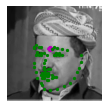

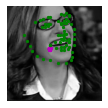

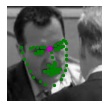

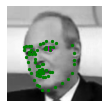

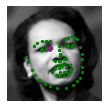

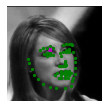

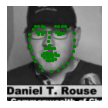

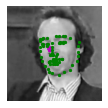

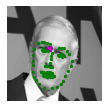

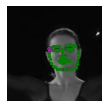

In [ ]:
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

In [ ]:
import torch.optim as optim

#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(params = net.parameters(), lr = 0.001)

In [ ]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()
    v = []

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        avg_loss = 0.0
        number = 0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)
            #output_pts = output_pts.type(torch.FloatTensor)
            #print(output_pts.type)
            #print(key_pts.type)
            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                avg_loss = avg_loss * number
                avg_loss += running_loss/1000
                running_loss = 0.0
                number = number + 1
                avg_loss = avg_loss/number
        print('average loss:')
        print(avg_loss)
        v.append(avg_loss)                

    print('Finished Training')

In [ ]:
n_epochs = 10

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
# with active_session():
train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.005265996426343918
Epoch: 1, Batch: 20, Avg. Loss: 0.0026623184978961946
average loss:
0.003964157462120056
Epoch: 2, Batch: 10, Avg. Loss: 0.0019502172172069549
Epoch: 2, Batch: 20, Avg. Loss: 0.002127493515610695
average loss:
0.002038855366408825
Epoch: 3, Batch: 10, Avg. Loss: 0.001867662489414215
Epoch: 3, Batch: 20, Avg. Loss: 0.0019148568212985992
average loss:
0.0018912596553564071
Epoch: 4, Batch: 10, Avg. Loss: 0.0019282024055719375
Epoch: 4, Batch: 20, Avg. Loss: 0.001900548830628395
average loss:
0.0019143756181001664
Epoch: 5, Batch: 10, Avg. Loss: 0.0019157403260469438
Epoch: 5, Batch: 20, Avg. Loss: 0.002028502985835075
average loss:
0.0019721216559410093
Epoch: 6, Batch: 10, Avg. Loss: 0.0019359946846961974
Epoch: 6, Batch: 20, Avg. Loss: 0.0017907632440328598
average loss:
0.0018633789643645285
Epoch: 7, Batch: 10, Avg. Loss: 0.001984542727470398
Epoch: 7, Batch: 20, Avg. Loss: 0.0019005275070667267
average loss:
0.0019425351172685623


In [ ]:
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([128, 1, 224, 224])
torch.Size([128, 68, 2])
torch.Size([128, 68, 2])


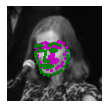

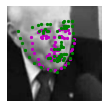

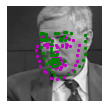

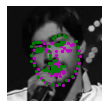

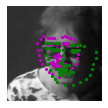

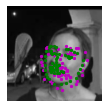

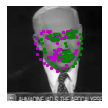

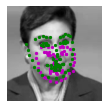

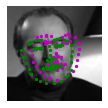

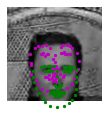

In [ ]:
visualize_output(test_images, test_outputs, gt_pts)

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
nsamples, nx, ny = test_outputs.shape
test_ops = test_outputs.reshape((nsamples,nx*ny))
test_ops = test_ops.detach().numpy()

nsamples, nx, ny = gt_pts.shape
gtps = gt_pts.reshape((nsamples,nx*ny))
gtps = gtps.detach().numpy()

rms = sqrt(mean_squared_error(test_ops, gtps))
print(rms)

0.35806510486982457


[[-0.14247565  0.02791884 -0.18028012  0.07552172  0.0073517 ]
 [ 0.07444234  0.01997175  0.15718563 -0.12963578  0.17289113]
 [ 0.02210201 -0.10674002 -0.12286363 -0.07463408 -0.02716693]
 [-0.06591683 -0.15642013  0.17158979 -0.15604793 -0.15070893]
 [-0.12822495  0.07475855 -0.01065225 -0.15081951 -0.09121253]]
(5, 5)


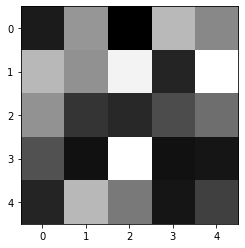

In [ ]:
net = net.cpu()

weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 10

print(w[filter_index][0])
print(w[filter_index][0].shape)

plt.imshow(w[filter_index][0], cmap='gray')

In [ ]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

some_image = mpimg.imread('images/mona_lisa.jpg')
some_img_copy = some_image.copy()
some_img_gray = cv2.cvtColor(some_img_copy, cv2.COLOR_RGB2GRAY)

# Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
feature_map = cv2.filter2D(some_img_gray, -1, w[10][0])

f, ax = plt.subplots(1, 2)
ax[0].imshow(some_img_gray, cmap='gray')
ax[0].set_title('original image')
ax[1].imshow(feature_map, cmap='gray')
ax[1].set_title('filtered image')

FileNotFoundError: ignored

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms, utils
import models
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=18432, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=136, bias=True)
  (drop1): Dropout(p=0.1, inplace=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (drop3): Dropout(p=0.3, inplace=False)
  (dr

In [ ]:
batch_size = 64

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

In [ ]:
batch_size = 64

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

In [ ]:
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([64, 1, 224, 224])
torch.Size([64, 68, 2])
torch.Size([64, 68, 2])


In [ ]:
import torch.optim as optim

#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(params = net.parameters(), lr = 0.001)

In [ ]:
n_epochs = 5 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
# with active_session():
train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.00276049043238163
Epoch: 1, Batch: 20, Avg. Loss: 0.0021152156442403795
Epoch: 1, Batch: 30, Avg. Loss: 0.0021331649273633956
Epoch: 1, Batch: 40, Avg. Loss: 0.001983302131295204
Epoch: 1, Batch: 50, Avg. Loss: 0.0020590524971485138
average loss:
0.0022102451264858244
Epoch: 2, Batch: 10, Avg. Loss: 0.0021782445311546326
Epoch: 2, Batch: 20, Avg. Loss: 0.0018534254729747773
Epoch: 2, Batch: 30, Avg. Loss: 0.0019069338887929917
Epoch: 2, Batch: 40, Avg. Loss: 0.001888363391160965
Epoch: 2, Batch: 50, Avg. Loss: 0.002202868029475212
average loss:
0.002005967062711716
Epoch: 3, Batch: 10, Avg. Loss: 0.0018039517253637314
Epoch: 3, Batch: 20, Avg. Loss: 0.0018155318796634675
Epoch: 3, Batch: 30, Avg. Loss: 0.0015641960799694062
Epoch: 3, Batch: 40, Avg. Loss: 0.0016345772445201874
Epoch: 3, Batch: 50, Avg. Loss: 0.0018734069615602494
average loss:
0.0017383327782154085
Epoch: 4, Batch: 10, Avg. Loss: 0.0015489364489912987
Epoch: 4, Batch: 20, Avg. Loss: 0.

In [ ]:
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([64, 1, 224, 224])
torch.Size([64, 68, 2])
torch.Size([64, 68, 2])


In [ ]:
visualize_output(test_images, test_outputs, gt_pts, batch_size)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


In [ ]:
nsamples, nx, ny = test_outputs.shape
test_ops = test_outputs.reshape((nsamples,nx*ny))
test_ops = test_ops.detach().numpy()

nsamples, nx, ny = gt_pts.shape
gtps = gt_pts.reshape((nsamples,nx*ny))
gtps = gtps.detach().numpy()

rms = sqrt(mean_squared_error(test_ops, gtps))
print(rms)

0.4429380453250662


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms, utils
import models
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=18432, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=136, bias=True)
  (drop1): Dropout(p=0.1, inplace=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (drop3): Dropout(p=0.3, inplace=False)
  (dr

In [ ]:
batch_size = 32

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

In [ ]:
batch_size = 32

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

In [ ]:
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([32, 1, 224, 224])
torch.Size([32, 68, 2])
torch.Size([32, 68, 2])


In [ ]:
import torch.optim as optim

#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(params = net.parameters(), lr = 0.001)

In [ ]:
n_epochs = 5 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
# with active_session():
train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.0029618911743164063
Epoch: 1, Batch: 20, Avg. Loss: 0.0024149832725524904
Epoch: 1, Batch: 30, Avg. Loss: 0.0019496019333600997
Epoch: 1, Batch: 40, Avg. Loss: 0.0020255144238471986
Epoch: 1, Batch: 50, Avg. Loss: 0.0018646818175911903
Epoch: 1, Batch: 60, Avg. Loss: 0.001694496512413025
Epoch: 1, Batch: 70, Avg. Loss: 0.0018535064458847046
Epoch: 1, Batch: 80, Avg. Loss: 0.0020776166170835496
Epoch: 1, Batch: 90, Avg. Loss: 0.002185104936361313
Epoch: 1, Batch: 100, Avg. Loss: 0.0021660971194505693
average loss:
0.002119349425286055
Epoch: 2, Batch: 10, Avg. Loss: 0.0019106834679841996
Epoch: 2, Batch: 20, Avg. Loss: 0.0020555066615343094
Epoch: 2, Batch: 30, Avg. Loss: 0.0017662042081356048
Epoch: 2, Batch: 40, Avg. Loss: 0.001836812198162079
Epoch: 2, Batch: 50, Avg. Loss: 0.0018855253159999847
Epoch: 2, Batch: 60, Avg. Loss: 0.0017945291697978973
Epoch: 2, Batch: 70, Avg. Loss: 0.001730514794588089
Epoch: 2, Batch: 80, Avg. Loss: 0.0015890266150236

In [ ]:
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([32, 1, 224, 224])
torch.Size([32, 68, 2])
torch.Size([32, 68, 2])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


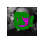

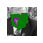

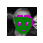

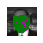

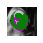

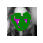

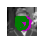

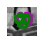

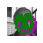

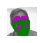

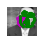

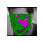

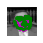

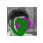

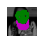

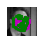

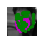

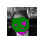

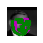

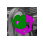

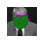

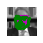

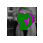

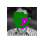

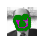

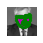

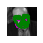

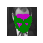

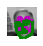

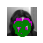

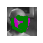

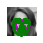

In [ ]:
visualize_output(test_images, test_outputs, gt_pts, batch_size)

In [ ]:
nsamples, nx, ny = test_outputs.shape
test_ops = test_outputs.reshape((nsamples,nx*ny))
test_ops = test_ops.detach().numpy()

nsamples, nx, ny = gt_pts.shape
gtps = gt_pts.reshape((nsamples,nx*ny))
gtps = gtps.detach().numpy()

rms = sqrt(mean_squared_error(test_ops, gtps))
print(rms)

0.34466673597533554


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms, utils
import models
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=18432, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=136, bias=True)
  (drop1): Dropout(p=0.1, inplace=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (drop3): Dropout(p=0.3, inplace=False)
  (dr

In [ ]:
batch_size = 16

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

In [ ]:
batch_size = 16

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

In [ ]:
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([16, 1, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


In [ ]:
import torch.optim as optim

#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(params = net.parameters(), lr = 0.001)

In [ ]:
n_epochs = 10 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
# with active_session():
train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.0026884856969118117
Epoch: 1, Batch: 20, Avg. Loss: 0.0021486561745405197
Epoch: 1, Batch: 30, Avg. Loss: 0.002115604445338249
Epoch: 1, Batch: 40, Avg. Loss: 0.0022257876992225647
Epoch: 1, Batch: 50, Avg. Loss: 0.0019451074972748757
Epoch: 1, Batch: 60, Avg. Loss: 0.0019458824917674064
Epoch: 1, Batch: 70, Avg. Loss: 0.002207922428846359
Epoch: 1, Batch: 80, Avg. Loss: 0.0019634951576590538
Epoch: 1, Batch: 90, Avg. Loss: 0.0021244159415364267
Epoch: 1, Batch: 100, Avg. Loss: 0.0018446367904543877
Epoch: 1, Batch: 110, Avg. Loss: 0.001983971118927002
Epoch: 1, Batch: 120, Avg. Loss: 0.0019493701457977295
Epoch: 1, Batch: 130, Avg. Loss: 0.001778971701860428
Epoch: 1, Batch: 140, Avg. Loss: 0.0018839287161827088
Epoch: 1, Batch: 150, Avg. Loss: 0.0022413912266492845
Epoch: 1, Batch: 160, Avg. Loss: 0.0019498509988188743
Epoch: 1, Batch: 170, Avg. Loss: 0.0018718235567212105
Epoch: 1, Batch: 180, Avg. Loss: 0.002676467724144459
Epoch: 1, Batch: 190, Av

In [ ]:
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([16, 1, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


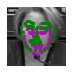

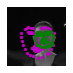

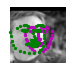

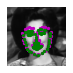

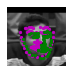

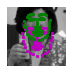

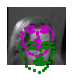

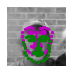

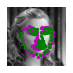

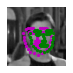

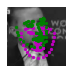

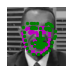

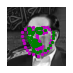

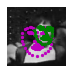

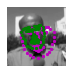

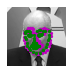

In [ ]:
visualize_output(test_images, test_outputs, gt_pts, batch_size)

In [ ]:
nsamples, nx, ny = test_outputs.shape
test_ops = test_outputs.reshape((nsamples,nx*ny))
test_ops = test_ops.detach().numpy()

nsamples, nx, ny = gt_pts.shape
gtps = gt_pts.reshape((nsamples,nx*ny))
gtps = gtps.detach().numpy()

rms = sqrt(mean_squared_error(test_ops, gtps))
print(rms)

0.44374320034332776


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms, utils
import models
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=18432, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=136, bias=True)
  (drop1): Dropout(p=0.1, inplace=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (drop3): Dropout(p=0.3, inplace=False)
  (dr

In [ ]:
batch_size = 32

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

In [ ]:
batch_size = 32

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

In [ ]:
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([32, 1, 224, 224])
torch.Size([32, 68, 2])
torch.Size([32, 68, 2])


In [ ]:
import torch.optim as optim

#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(params = net.parameters(), lr = 0.001)

In [ ]:
n_epochs = 5 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
# with active_session():
train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.0034870127588510513
Epoch: 1, Batch: 20, Avg. Loss: 0.0024577928930521013
Epoch: 1, Batch: 30, Avg. Loss: 0.002285507872700691
Epoch: 1, Batch: 40, Avg. Loss: 0.0019518100023269652
Epoch: 1, Batch: 50, Avg. Loss: 0.0021053221672773363
Epoch: 1, Batch: 60, Avg. Loss: 0.0019335313588380813
Epoch: 1, Batch: 70, Avg. Loss: 0.0019318277537822724
Epoch: 1, Batch: 80, Avg. Loss: 0.0020162016600370407
Epoch: 1, Batch: 90, Avg. Loss: 0.0019887807369232176
Epoch: 1, Batch: 100, Avg. Loss: 0.0021875207871198655
average loss:
0.0022345307990908623
Epoch: 2, Batch: 10, Avg. Loss: 0.001970061004161835
Epoch: 2, Batch: 20, Avg. Loss: 0.0020862284153699874
Epoch: 2, Batch: 30, Avg. Loss: 0.0017855988442897796
Epoch: 2, Batch: 40, Avg. Loss: 0.0019670033156871797
Epoch: 2, Batch: 50, Avg. Loss: 0.002104588344693184
Epoch: 2, Batch: 60, Avg. Loss: 0.001960856810212135
Epoch: 2, Batch: 70, Avg. Loss: 0.0018299634903669356
Epoch: 2, Batch: 80, Avg. Loss: 0.001970447875559

In [ ]:
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([32, 1, 224, 224])
torch.Size([32, 68, 2])
torch.Size([32, 68, 2])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


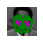

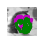

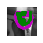

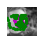

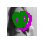

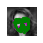

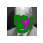

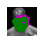

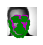

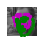

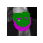

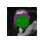

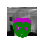

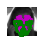

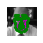

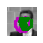

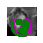

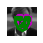

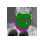

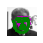

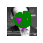

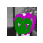

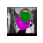

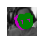

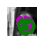

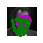

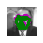

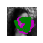

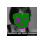

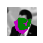

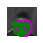

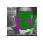

In [ ]:
visualize_output(test_images, test_outputs, gt_pts, batch_size)

In [ ]:
nsamples, nx, ny = test_outputs.shape
test_ops = test_outputs.reshape((nsamples,nx*ny))
test_ops = test_ops.detach().numpy()

nsamples, nx, ny = gt_pts.shape
gtps = gt_pts.reshape((nsamples,nx*ny))
gtps = gtps.detach().numpy()

rms = sqrt(mean_squared_error(test_ops, gtps))
print(rms)

0.3476709809808508


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms, utils
import models
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=18432, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=136, bias=True)
  (drop1): Dropout(p=0.1, inplace=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (drop3): Dropout(p=0.3, inplace=False)
  (dr

In [ ]:
batch_size = 32

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

In [ ]:
batch_size = 32

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

In [ ]:
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([32, 1, 224, 224])
torch.Size([32, 68, 2])
torch.Size([32, 68, 2])


In [ ]:
import torch.optim as optim

#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(params = net.parameters(), lr = 0.001)

In [ ]:
n_epochs = 6 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
# with active_session():
train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.003272086352109909
Epoch: 1, Batch: 20, Avg. Loss: 0.0021291727125644683
Epoch: 1, Batch: 30, Avg. Loss: 0.0020766577124595644
Epoch: 1, Batch: 40, Avg. Loss: 0.0019624203741550445
Epoch: 1, Batch: 50, Avg. Loss: 0.0023204372227191923
Epoch: 1, Batch: 60, Avg. Loss: 0.0021478348821401595
Epoch: 1, Batch: 70, Avg. Loss: 0.0023034010678529737
Epoch: 1, Batch: 80, Avg. Loss: 0.0021635132580995558
Epoch: 1, Batch: 90, Avg. Loss: 0.0017994425147771836
Epoch: 1, Batch: 100, Avg. Loss: 0.0023115233778953554
average loss:
0.0022486489474773407
Epoch: 2, Batch: 10, Avg. Loss: 0.001917157843708992
Epoch: 2, Batch: 20, Avg. Loss: 0.002593199700117111
Epoch: 2, Batch: 30, Avg. Loss: 0.001863747239112854
Epoch: 2, Batch: 40, Avg. Loss: 0.0017410543709993362
Epoch: 2, Batch: 50, Avg. Loss: 0.0018001501113176345
Epoch: 2, Batch: 60, Avg. Loss: 0.0019153967499732972
Epoch: 2, Batch: 70, Avg. Loss: 0.0021553742066025734
Epoch: 2, Batch: 80, Avg. Loss: 0.002004263952374

In [ ]:
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([32, 1, 224, 224])
torch.Size([32, 68, 2])
torch.Size([32, 68, 2])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


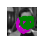

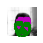

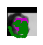

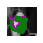

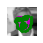

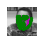

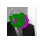

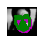

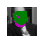

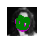

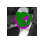

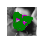

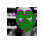

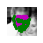

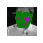

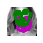

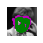

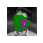

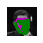

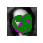

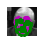

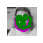

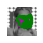

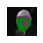

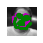

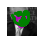

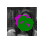

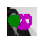

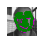

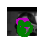

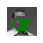

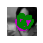

In [ ]:
visualize_output(test_images, test_outputs, gt_pts, batch_size)

In [ ]:
nsamples, nx, ny = test_outputs.shape
test_ops = test_outputs.reshape((nsamples,nx*ny))
test_ops = test_ops.detach().numpy()

nsamples, nx, ny = gt_pts.shape
gtps = gt_pts.reshape((nsamples,nx*ny))
gtps = gtps.detach().numpy()

rms = sqrt(mean_squared_error(test_ops, gtps))
print(rms)

0.38489263012986347


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms, utils
import models2
from models2 import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=18432, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=136, bias=True)
  (drop1): Dropout(p=0.1, inplace=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (drop3): Dropout(p=0.3, inplace=False)
  (dr

In [ ]:
batch_size = 32

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

In [ ]:
batch_size = 32

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

In [ ]:
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([32, 1, 224, 224])
torch.Size([32, 68, 2])
torch.Size([32, 68, 2])


In [ ]:
import torch.optim as optim

#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(params = net.parameters(), lr = 0.001)

In [ ]:
n_epochs = 8 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
# with active_session():
train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.0034295672476291656
Epoch: 1, Batch: 20, Avg. Loss: 0.002475913420319557
Epoch: 1, Batch: 30, Avg. Loss: 0.0021147341281175613
Epoch: 1, Batch: 40, Avg. Loss: 0.001906003013253212
Epoch: 1, Batch: 50, Avg. Loss: 0.0020650522857904433
Epoch: 1, Batch: 60, Avg. Loss: 0.0018998320400714875
Epoch: 1, Batch: 70, Avg. Loss: 0.0018270208835601807
Epoch: 1, Batch: 80, Avg. Loss: 0.0022650445848703383
Epoch: 1, Batch: 90, Avg. Loss: 0.0019364179447293281
Epoch: 1, Batch: 100, Avg. Loss: 0.0019335774183273315
average loss:
0.0021853162966668604
Epoch: 2, Batch: 10, Avg. Loss: 0.0020466764122247694
Epoch: 2, Batch: 20, Avg. Loss: 0.0021023385524749755
Epoch: 2, Batch: 30, Avg. Loss: 0.001772488221526146
Epoch: 2, Batch: 40, Avg. Loss: 0.0018000811040401459
Epoch: 2, Batch: 50, Avg. Loss: 0.0018646561056375503
Epoch: 2, Batch: 60, Avg. Loss: 0.002002622216939926
Epoch: 2, Batch: 70, Avg. Loss: 0.001980321392416954
Epoch: 2, Batch: 80, Avg. Loss: 0.0017548785209655

KeyboardInterrupt: ignored

In [ ]:
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

In [ ]:
visualize_output(test_images, test_outputs, gt_pts, batch_size)

In [ ]:
nsamples, nx, ny = test_outputs.shape
test_ops = test_outputs.reshape((nsamples,nx*ny))
test_ops = test_ops.detach().numpy()

nsamples, nx, ny = gt_pts.shape
gtps = gt_pts.reshape((nsamples,nx*ny))
gtps = gtps.detach().numpy()

rms = sqrt(mean_squared_error(test_ops, gtps))
print(rms)